<a href="https://colab.research.google.com/github/purvasingh96/Deep-learning-with-neural-networks/blob/master/Chapter-wise%20code/Code%20-%20PyTorch/4.%20Generative%20Adversarial%20Networks%20(GANs)/2.%20Deep%20Convolution%20GANs/Deep_Convolution_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

%matplotlib inline

In [0]:
import torch
from torchvision import datasets
from torchvision import transforms


In [20]:
transform = transforms.ToTensor()
svhn_train = datasets.SVHN(root='sample_data/', split='train', transform=transform, download=True)

batch_size = 128
num_workers = 0

train_loader = torch.utils.data.DataLoader(svhn_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Using downloaded and verified file: sample_data/train_32x32.mat


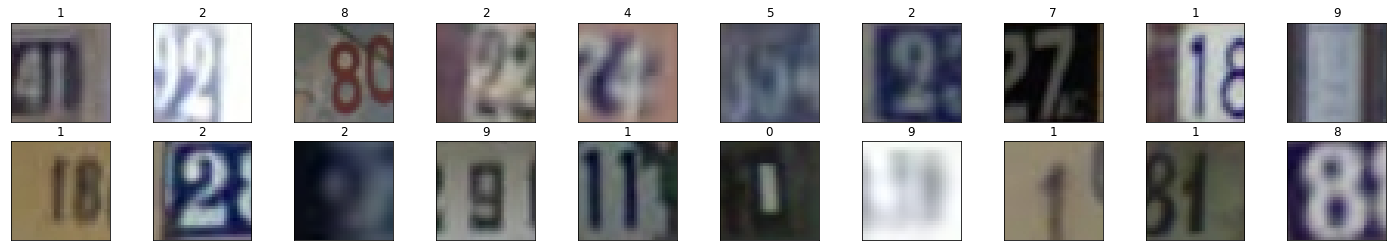

In [21]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [22]:
img = images[5]

print('Min : ', img.min())
print('Max : ', img.max())

Min :  tensor(0.2000)
Max :  tensor(0.5922)


In [0]:
def scale(x, feature_range=(-1, 1)):
  min_, max_ = feature_range
  return x*(max_-min_)-max_

In [24]:
scaled_image = scale(img)

print('Min : ', scaled_image.min())
print('Max : ', scaled_image.max())

Min :  tensor(-0.6000)
Max :  tensor(0.1843)


In [0]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  layers = []
  conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(conv_layer)
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  
  return nn.Sequential(*layers)

In [0]:
class Discriminator(nn.Module):
  def __init__(self, conv_dim=32):
    super(Discriminator, self).__init__()
    self.conv_dim = conv_dim

    self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
    self.conv2 = conv(conv_dim, conv_dim*2, 4)
    self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

    self.fc = nn.Linear(conv_dim*4*4*4, 1)
  
  def forward(self, x):
    # x = 32*32
    out = F.leaky_relu(self.conv1(x), 0.2)
    out = F.leaky_relu(self.conv2(out), 0.2)
    out = F.leaky_relu(self.conv3(out), 0.2)

    out = out.view(-1, self.conv_dim*4*4*4)
    out = self.fc(out)
    return out

In [0]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  layers=[]
  transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, batch_norm)
  layers.append(transpose_conv_layer)
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  
  return nn.Sequential(*layers)

In [0]:
class Generator(nn.Module):
  def __init__(self, z_dim, conv_dim=32):
    super(Generator, self).__init__()
    self.conv_dim = conv_dim

    # produce output of 4*4*128
    self.fc = nn.Linear(z_dim, conv_dim*4*4*4)
    self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
    self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
    self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
  
  def forward(self, x):
    out = self.fc(x)
    out = out.view(-1, self.conv_dim*4 , 4, 4)

    out = F.relu(self.t_conv1(out))
    out = F.relu(self.t_conv2(out))

    out = F.tanh(self.t_conv3(out))

    return out


In [59]:
conv_dim = 32
z_dim = 100

D = Discriminator(conv_dim=conv_dim)
G = Generator(z_dim=z_dim, conv_dim=conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(True, True))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), pad

In [60]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  D.cuda()
  G.cuda()
  print('Training on GPU')
else:
  print('Training on CPU')

Training on GPU


In [0]:
def real_loss(D_out, smooth=False):
  batch_size = D_out.size(0)
  if smooth:
    labels = torch.ones(batch_size)*0.9
  else:
    labels = torch.ones(batch_size)
  
  if train_on_gpu:
    labels = labels.cuda()
  
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)
  return loss

def fake_loss(D_out):
  batch_size=D_out.size(0)
  labels = torch.zeros(batch_size)
  if train_on_gpu:
    labels = labels.cuda() 
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)
  
  return loss

In [0]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [63]:
import pickle as pkl

# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_dim))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        #real_images = scale(real_images)
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   50] | d_loss: 1.3862 | g_loss: 0.9489
Epoch [    1/   50] | d_loss: 0.0051 | g_loss: 6.2292
Epoch [    2/   50] | d_loss: 0.0020 | g_loss: 7.2542
Epoch [    2/   50] | d_loss: 0.0016 | g_loss: 7.9397
Epoch [    3/   50] | d_loss: 0.0006 | g_loss: 8.0710
Epoch [    3/   50] | d_loss: 0.0004 | g_loss: 8.7190
Epoch [    4/   50] | d_loss: 0.0004 | g_loss: 9.3175
Epoch [    4/   50] | d_loss: 0.0003 | g_loss: 9.2973
Epoch [    5/   50] | d_loss: 0.0001 | g_loss: 9.8976
Epoch [    5/   50] | d_loss: 0.0001 | g_loss: 10.3831
Epoch [    6/   50] | d_loss: 0.0001 | g_loss: 10.1112
Epoch [    6/   50] | d_loss: 0.0000 | g_loss: 10.4135
Epoch [    7/   50] | d_loss: 0.0000 | g_loss: 10.6578
Epoch [    7/   50] | d_loss: 0.0000 | g_loss: 10.9394
Epoch [    8/   50] | d_loss: 0.0000 | g_loss: 11.1452
Epoch [    8/   50] | d_loss: 0.0000 | g_loss: 11.3949
Epoch [    9/   50] | d_loss: 0.0000 | g_loss: 12.2613
Epoch [    9/   50] | d_loss: 0.0000 | g_loss: 11.4955
Epoch [   10/   50]

KeyboardInterrupt: ignored

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        #im = ax.imshow(img.reshape((32,32,3)))

In [0]:
_ = view_samples(-1, samples)